## Option Pricing

In [3]:
import yfinance as yfin
import numpy as np 
import pandas as pd 
import pandas_datareader.data as pdr
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import datetime

yfin.pdr_override()

# List of stock symbols
ticker = 'META'

# Set the date range for the historical data
start_date = '2020-08-01'

# Get today's date
today = datetime.date.today()
print("Today is: ", today)
 
# Yesterday date
yesterday = today - datetime.timedelta(days = 1)

# Get the current date
current_date = yesterday

# Calculate the start date one year ago
start_date = current_date - datetime.timedelta(days=365)

# Calculate the end date as today
end_date = current_date


# Download historical stock data for each stock

stock = pdr.get_data_yahoo(ticker, start_date, end_date)



Today is:  2023-11-05
[*********************100%***********************]  1 of 1 completed


In [4]:
today

datetime.date(2023, 11, 5)

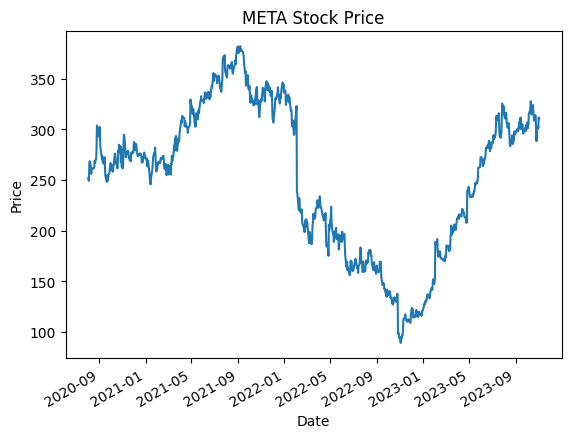

In [26]:
# Plot the stock price
stock['Close'].plot(ylabel='Price',title=f"{ticker} Stock Price")
plt.show()

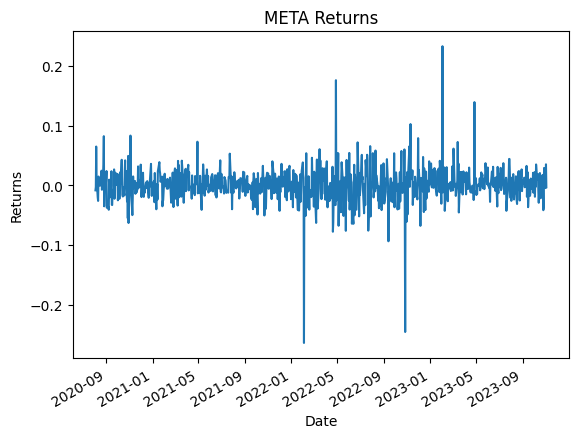

In [27]:
stock['Returns'] = stock['Close'].pct_change()


stock['Returns'].plot(ylabel='Returns',title=f"{ticker} Returns")
plt.show()


In [28]:
from statsmodels.tsa.stattools import adfuller
# Testing stationarity
stat_test = adfuller(stock['Returns'].dropna())[0:2]
print(f"The test statistic and p-value of ADF test are {stat_test}")
if stat_test[1] < 0.05:
    print("The data is stationary")
else:
    print("The data is not stationary")


The test statistic and p-value of ADF test are (-28.66976359493852, 0.0)
The data is stationary


### Estimating volatility

Use weighted returns to calculate the volatility from the historical data.
Exponential weighted moving average can be used get an estimate

$\sigma_{n}=(1-\lambda)\Sigma_{1}^{\inf}\lambda^{i-1}R^{2}_{n-i+1}$

Analysing with three values of $\lambda=0.85,0.9,0.95$

In [29]:
import numpy as np 

def get_volatility(returns,j,lmb):
    N=returns.shape[0]
    sig=0
    for i in range(1,N):
        sig += (lmb**(i-1))*returns[j-i+1]**2
    sig *= (1-lmb)
    return sig

stock['Returns'].fillna(0,inplace=True)

stock['EMAV85'] = 0
stock['EMAV90'] = 0
stock['EMAV95'] = 0

# vol = np.zeros(len(stock['Returns']))
for j in range(len(stock['Returns'])):
    stock['EMAV85'].iat[j] = np.sqrt(get_volatility(stock['Returns'].values,j,0.85))
    stock['EMAV90'].iat[j] = np.sqrt(get_volatility(stock['Returns'].values,j,0.90))
    stock['EMAV95'].iat[j] = np.sqrt(get_volatility(stock['Returns'].values,j,0.95))


<Axes: xlabel='Date'>

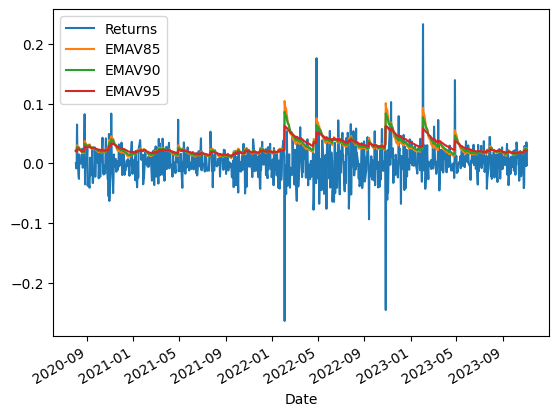

In [30]:
stock[['Returns','EMAV85','EMAV90','EMAV95']].plot()


For low values of lambda EWMA is more reactive to big market events but the high volatility dies quickly.
It is a good idea to check the values by setting lambda close to one. The low values of lambda in a period of low volatility can give you low values of volatility, this value can be misleading. Extreme events can occur in future. The high value of lambda can be used as a limiting case of volatility.

## Binomial Pricing Model

### Get risk free rate

In [12]:
import yfinance as yf

# Define the ticker symbol for the 1-year US Treasury bond
treasury_symbol = "^IRX"  # ^IRX is the symbol for the 1-Year US Treasury Yield

# Create a Ticker object
treasury = yf.Ticker(treasury_symbol)

# Get the historical data for the Treasury bond
treasury_data = treasury.history(period="1d")  # Fetching a single day's data

# Extract the yield for today
risk_free_rate = treasury_data['Open'][0]

print(f"1-year US Treasury Bond Rate: {risk_free_rate}%")


1-year US Treasury Bond Rate: 5.289999961853027%


### Variation with volatility

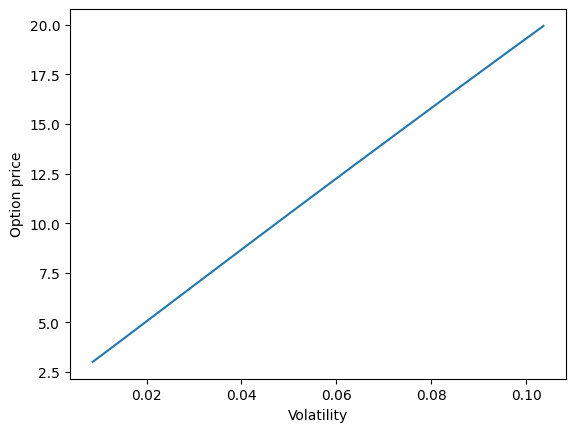

In [31]:
from Option_pricing import Pricing_Models

volatility = stock.EMAV85.values[-1]
# options
current_price = stock.Close[-1]
strike_price = current_price +2
Expiry = 0.2
dt = 1/252.0
t=0.1
risk_free_rate = 0.528

option_price=[]
sigma_range=np.arange(stock.EMAV85.values.min(),stock.EMAV85.values.max(),0.001)
for sigma in sigma_range:
    models = Pricing_Models(strike_price, risk_free_rate, Expiry, sigma,dt)
    option_price.append(models.binomial_pricing(current_price,t))

fig,ax = plt.subplots(1,1)
ax.set_xlabel(r'Volatility')
ax.set_ylabel(r'Option price')
ax.plot(sigma_range,option_price)

plt.show()


### Variation with time to expiry

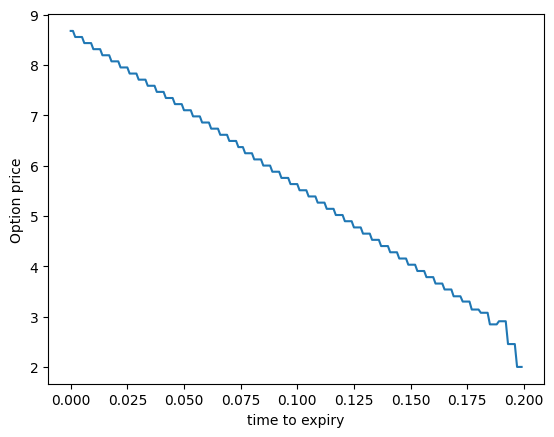

In [32]:
from Option_pricing import Pricing_Models

volatility = stock.EMAV85.values[-1]
# options
current_price = stock.Close[-1]
strike_price = current_price+2
risk_free_rate = 0.05
Expiry = 0.2
dt = 1/252.0

option_price=[]
timetowxp=np.arange(0,Expiry,0.001)
for t in timetowxp:
    models = Pricing_Models(strike_price, risk_free_rate, Expiry, volatility,dt)
    option_price.append(models.binomial_pricing(current_price,t))

fig,ax = plt.subplots(1,1)
ax.set_xlabel(r'time to expiry')
ax.set_ylabel(r'Option price')
ax.plot(timetowxp,option_price)

plt.show()


### Variation with date of Expiry

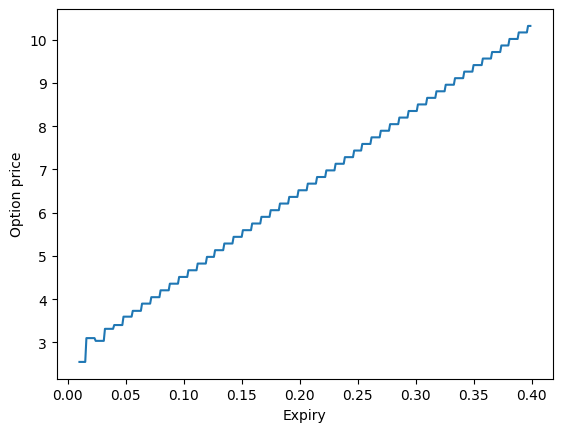

In [15]:
from Option_pricing import Pricing_Models

volatility = stock.EMAV85.values[-1]
# options
current_price = stock.Close[-1]
strike_price = current_price+2
risk_free_rate = 0.05
dt = 1/252.0
risk_free_rate = 0.528


option_price=[]
expiry_range=np.arange(0.01,0.4,0.001)
for Expiry in expiry_range:
    t=Expiry/2
    models = Pricing_Models(strike_price, risk_free_rate, Expiry, volatility,dt)
    option_price.append(models.binomial_pricing(current_price,t))

fig,ax = plt.subplots(1,1)
ax.set_xlabel(r'Expiry')
ax.set_ylabel(r'Option price')
ax.plot(expiry_range,option_price)

plt.show()


## Monte Carlo Method

Stocks follow the stochastic equation:
$dS(t) = S \mu dt + \sigma dW(t)$
where S is current stock price, $\mu$ is the mean return, $\sigma$ is volatility and $W$ is a Wiener process.
This equation translate into:

$ln (S(t)) = ln (S_{0}) \int_{0}^{1} (\mu - \sigma^{2}/2) dt + \int_{0}^{1} \sigma dW(t)$

$S(t)$ can take different paths for randomly selected $W(t)$ which is $\sqrt(T)\epsilon(0,1)$ with T is the time to expiry.

For a call option $payout=max(S(T)-K,0)$, discounting at risk free rate it gives the option price at the start for one trajectory of S(t):

$c_{i} = e^{-rT}max(S(T)-K,0)$

for N iterations of S(t) and taking mean of all the option price we get the option price:

$c = \frac{\Sigma_{i=1}^{N} c_{i}}{N}$ and similarly for put option.

In [33]:

import yfinance as yfin
import numpy as np 
import pandas as pd 
import pandas_datareader.data as pdr
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import datetime 
from Option_pricing import Pricing_Models


yfin.pdr_override()

def format_date(x):
    return x.strftime('%Y-%m-%d')


# List of stock symbols
ticker = 'META'



# get historical volatility
def get_volatility(data, tradedate):
    return data.Close.pct_change().std()*np.sqrt(252)


# Get the current date
current_date = datetime.date.today()

# Calculate the start date one year ago
start_date = current_date - datetime.timedelta(days=365)

# Calculate the end date as today
end_date = current_date

# Download historical stock data for each stock
stock_data = pdr.get_data_yahoo(ticker, start_date, end_date)

lastdate = datetime.date.today().strftime('%Y-%m-%d')

expiration = '2024-09-20'
stock_ticker = yfin.Ticker(ticker)
# Fetch options data
options_data = stock_ticker.option_chain(expiration)
# print(options_data.calls['inTheMoney'])
# options_data.calls.plot(x='strike',y='lastPrice')
calls = options_data.calls
puts = options_data.puts

calls['lastTradeDate'] = calls['lastTradeDate'].apply(format_date)
puts['lastTradeDate'] = puts['lastTradeDate'].apply(format_date)

# risk free rate
risk_free_rate = 0.528

      
# print(strike,strike_df.lastTradeDate.values[0])

# risk_free_rate = 0.05
deltat = 1/252.0
steps = 100


mc_price = []
op_price = []

strike_price = calls['strike']

for strike in strike_price.values:
    strike_df = calls[calls['strike']==strike]

    for tradedate in strike_df['lastTradeDate'].values:
            
        if tradedate != lastdate:

            # get historicak volatility
                volatility = get_volatility(stock_data,tradedate)

                N=10000
                exp = datetime.datetime.strptime(expiration, '%Y-%m-%d')
                tdate = datetime.datetime.strptime(tradedate, '%Y-%m-%d')
                Expiry = (exp - tdate).days/252
                deltat = 1.0/252

                # create model object
                model = Pricing_Models(strike,risk_free_rate,Expiry,volatility,deltat)

                # get stock price at trade date
                stock_price = stock_data.loc[stock_data.index==tradedate,'Close']
                op_price.append(strike_df.loc[strike_df.lastTradeDate==tradedate,'lastPrice'].values[0])

                # get option price using Monte Carlo
                mc_price.append(model.MonteCarlo(stock_price.values[0],N,'call'))


            

[*********************100%***********************]  1 of 1 completed


In [34]:
rmse = np.sqrt(np.mean((np.array(mc_price)-np.array(op_price))**2))
print(rmse)

11.502115010340122


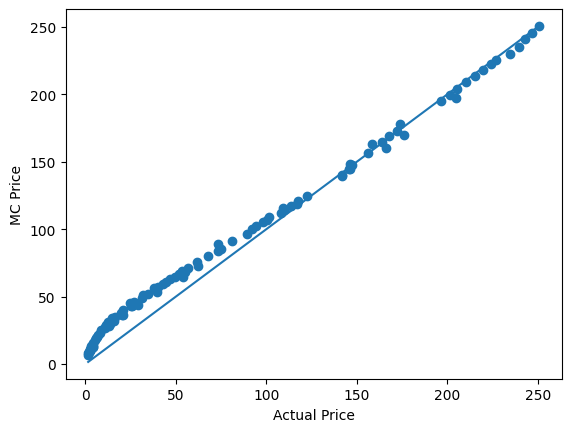

In [35]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel(r'Actual Price')
ax.set_ylabel(r'MC Price')

ax.scatter(op_price,mc_price)
ax.plot([min(op_price),max(op_price)],[min(op_price),max(op_price)])

## Black-Scholes Model

Black-Scholes option pricing formula for European call options:

$C = S \cdot N(d_1) - X \cdot e^{-rT} \cdot N(d_2)$ 

$P =  X \cdot e^{-rT} \cdot N(-d_2)-S \cdot N(-d_1)$

Where:
- $C$ and $P$ are the call and put options price.
- $S$ is the current stock price.
- $N(d_1)$ is the cumulative standard normal distribution function evaluated at \(d_1\).
- $X$ is the option's strike price.
- $r$ is the risk-free interest rate.
- $T$ is the time to expiration.
- $N(d_2)$ is the cumulative standard normal distribution function evaluated at \(d_2\).

The values of $d_1$ and $d_2$ are calculated as follows:

$d_1 = \frac{\ln(S_0 / X) + (r + \sigma^2 / 2)T}{\sigma\sqrt{T}}$

$d_2 = d_1 - \sigma\sqrt{T}$

This formula is used to calculate the price of a European call option. If you need the formula for a put option, you can use the put-call parity relationship, which relates the prices of European call and put options.

For every expiration rate, we will have a range of strike price, their option prices, their last date of trading of that option.

In [19]:

import yfinance as yfin
import numpy as np 
import pandas as pd 
import pandas_datareader.data as pdr
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import date


yfin.pdr_override()

def format_date(x):
    return x.strftime('%Y-%m-%d')


# List of stock symbols
ticker = 'META'

import datetime

# Get the current date
current_date = datetime.date.today()

# Calculate the start date one year ago
start_date = current_date - datetime.timedelta(days=365)

# Calculate the end date as today
end_date = current_date

# Download historical stock data for each stock
stock_data = pdr.get_data_yahoo(ticker, start_date, end_date)


expiration = '2024-09-20'
stock_ticker = yfin.Ticker(ticker)
# Fetch options data
options_data = stock_ticker.option_chain(expiration)
# print(options_data.calls['inTheMoney'])
# options_data.calls.plot(x='strike',y='lastPrice')
calls = options_data.calls
puts = options_data.puts

calls['lastTradeDate'] = calls['lastTradeDate'].apply(format_date)
puts['lastTradeDate'] = puts['lastTradeDate'].apply(format_date)


[*********************100%***********************]  1 of 1 completed


In [20]:
from datetime import datetime
from Option_pricing import Pricing_Models

# get historical volatility
def get_volatility(data, tradedate):
    return data.Close.pct_change().std()*np.sqrt(252)

risk_free_rate = 0.528
deltat = 1/252.0
lastdate = date.today().strftime('%Y-%m-%d')
# iterate over each strike price
strike_price = calls['strike']
            
BS_price = []
op_price=[]
for strike in strike_price:
    strike_df = calls[calls['strike']==strike]
    # print(strike,strike_df.lastTradeDate.values[0])
    
    for tradedate in strike_df['lastTradeDate'].values:
        
        if tradedate != lastdate:

            # get historicak volatility
            volatility = get_volatility(stock_data,tradedate)


            exp = datetime.strptime(expiration, '%Y-%m-%d')
            tdate = datetime.strptime(tradedate, '%Y-%m-%d')
            Expiry = (exp - tdate).days/252
            deltat = 1.0/252

            # create model object
            model = Pricing_Models(strike,risk_free_rate,Expiry,volatility,deltat)

            # get stock price at trade date
            stock_price = stock_data.loc[stock_data.index==tradedate,'Close']
            op_price.append(strike_df.loc[strike_df.lastTradeDate==tradedate,'lastPrice'].values[0])

            # get option price using Black Scholes
            BS_price.append(model.Black_Scholes(stock_price,"call"))



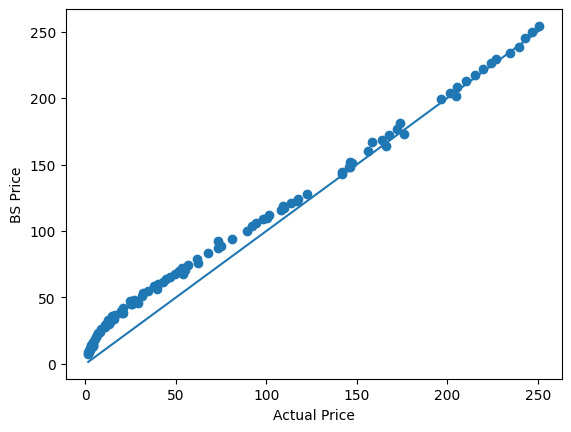

In [21]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel(r'Actual Price')
ax.set_ylabel(r'BS Price')
#ax.plot()
#ax.set_xlim()
#ax.set_ylim()

ax.scatter(op_price,BS_price)

ax.plot([min(op_price),max(op_price)],[min(op_price),max(op_price)])

Differences between Black-Scholes option prices and option prices obtained from real market data, like those on Yahoo Finance, are common. There are several reasons for this disparity, including:

- Market Factors: The Black-Scholes model assumes that markets are frictionless, which means there are no transaction costs, no bid-ask spreads, and continuous trading. In reality, these factors can significantly impact option prices.

- Implied Volatility: The Black-Scholes model uses a fixed volatility value. In contrast, market option prices are often determined by implied volatility, which reflects market expectations. Implied volatility can be higher or lower than historical volatility, leading to differences.

- Dividends and Interest Rates: The model assumes constant interest rates and no dividends. In reality, these values can change, affecting option prices.

- Market Supply and Demand: Option prices in the market are influenced by supply and demand, sentiment, and other market dynamics. The Black-Scholes model does not consider these factors.

- Market Liquidity: Liquidity conditions can impact option prices, especially for options with low trading volumes.

- Model Assumptions: The Black-Scholes model has several simplifying assumptions that may not hold in all cases, such as the assumption of log-normal price distributions.





## using Implied volatility

We use implied volatility as volatility in the Black Scholes model.

In [18]:
from Option_pricing import Pricing_Models
import datetime 

# get historical volatility
def get_volatility(data, tradedate):
    return data.Close.pct_change().std()*np.sqrt(252)

risk_free_rate = 0.528
deltat = 1/252.0
# iterate over each strike price
strike_price = calls['strike']


# List of stock symbols
ticker = 'META'

# Get today's date
today = datetime.date.today()
print("Today is: ", today)
 
# Yesterday date
yesterday = today - datetime.timedelta(days = 1)

# Get the current date
current_date = yesterday

# Calculate the start date one year ago
start_date = current_date - datetime.timedelta(days=365)

# Calculate the end date as today
end_date = current_date

# Download historical stock data for each stock
stock_data = pdr.get_data_yahoo(ticker, start_date, end_date)

lastdate = yesterday.strftime('%Y-%m-%d')

expiration = '2023-11-10'
          
BS_price = []
op_price=[]
for strike in strike_price:
    strike_df = calls[calls['strike']==strike]
    # print(strike,strike_df.lastTradeDate.values[0])
    
    for tradedate in strike_df['lastTradeDate'].values:
        
        if tradedate != lastdate:

            # get historicak volatility
            # volatility = get_volatility(stock_data,tradedate)


            exp = datetime.datetime.strptime(expiration, '%Y-%m-%d')
            tdate = datetime.datetime.strptime(tradedate, '%Y-%m-%d')
            Expiry = (exp - tdate).days/252
            deltat = 1.0/252

            volatility = strike_df.loc[strike_df.lastTradeDate==tradedate,'impliedVolatility'].values[0]

            # create model object
            model = Pricing_Models(strike,risk_free_rate,Expiry,volatility,deltat)

            # get stock price at trade date
            stock_price = stock_data.loc[stock_data.index==tradedate,'Close']
            op_price.append(strike_df.loc[strike_df.lastTradeDate==tradedate,'lastPrice'].values[0])

            # get option price using Black Scholes
            BS_price.append(model.Black_Scholes(stock_price,"call"))



Today is:  2023-11-05
[*********************100%***********************]  1 of 1 completed


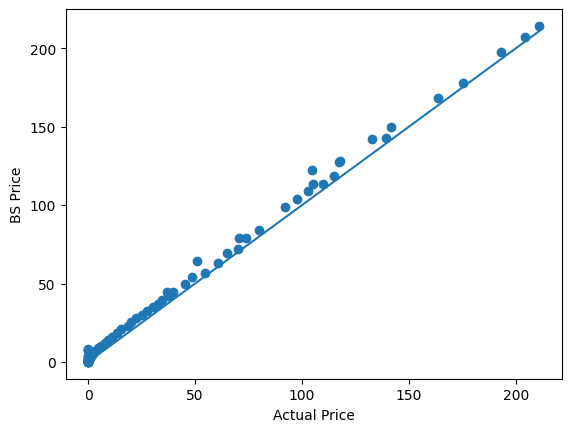

In [19]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel(r'Actual Price')
ax.set_ylabel(r'BS Price')
#ax.plot()
#ax.set_xlim()
#ax.set_ylim()

ax.scatter(op_price,BS_price)

ax.plot([min(op_price),max(op_price)],[min(op_price),max(op_price)])

Using the implied volatility the model prices match very closely to the Actual price from yahoo finance.
The little dicrepancy can be because of other factors discussed above.